In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

import boto3
import pandas as pd
from sagemaker import get_execution_role

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import category_encoders as ce

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [2]:
# Dataset

role = get_execution_role()
bucket='sagemaker-tagger'
data_key1 = 'Master_emails.csv'
data_location1 = 's3://{}/{}'.format(bucket, data_key1)

df = pd.read_csv(data_location1)

In [3]:
# Drop unneeded columns, nulls, and change message type to str

df.drop(columns=['Unnamed: 0'], inplace=True)
df['Message'] = df['Message'].apply(str)

print(df.shape)
df.dropna(inplace=True)
print(df.shape)

### EDA/Cleaning Function

In [4]:
df.head()

,Content_Type,From,Message,Subject,Tags,UID
0,text/plain,<grangepayments@westernunionspeedpay.com>,"Dear AVRAHAM JACOBSOHN, This is to confirm th...",Grange Payment Confirmation,Finance,31780
1,text/plain,Chase <no.reply.alerts@chase.com>,This is an Alert to help manage your account ...,Your Debit Card Transaction,Finance,31779
2,text/plain,Amazon Web Services <no-reply-aws@amazon.com>,Please let us know if we helped resolve your i...,Resolved 6559329691: Limit Increase: SageMaker,Productivity,31738
3,text/plain,Lambda Labs <noreply@github.com>,Youve been added to the Labs 18 - Tagger team ...,Bernie Durfee added you to the Lambda Labs tea...,Productivity,31693
4,text/plain,Amazon Web Services <no-reply-aws@amazon.com>,"Hello, We haven't heard back from you regard...",Attention required on case 6559329691: Limit I...,Productivity,31684


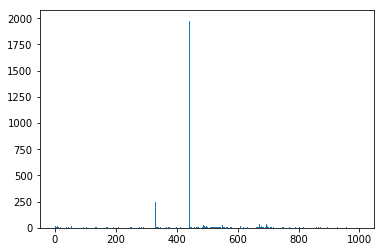

In [5]:
# Text length
df['Text_Length'] = df['Message'].apply(str)
df['Text_Length'] = df['Text_Length'].apply(len)

# Too many messages have the same length, too many of the same email from Amazon
plt.hist(df['Text_Length'].values, bins = range(0, 1000, 1));

In [6]:
# Function to clean the text prior to tokenizing

def clean_text(text):
    # Perform a few cleaning steps to remove non-alphabetic characters
    
    text = text.replace("\n", " ").replace("\r", " ")
    
    punc_list = '!@#$%^&*()+?-_=:.<>[]{}/\~",' + '1234567890'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)
    
    return text   

In [7]:
# Compare before and after clean function

df['Clean_Message'] = df['Message'].apply(clean_text)
print(df['Message'][2], '   SPACE   ',  df['Clean_Message'][2])

Please let us know if we helped resolve your issue:   If YES, click here: https://console.aws.amazon.com/support/feedback?eventId=6559329691&language=en&questionnaireId=Support-HMD-Yes  If NO, click here: https://console.aws.amazon.com/support/feedback?eventId=6559329691&language=en&questionnaireId=Support-HMD-No   To contact us again about this case, please return to the AWS Support Center using the following URL:   https://console.aws.amazon.com/support/home?#/case/?caseId=6559329691&displayId=6559329691&language=en  (If you will connect by federation, log in before following the link.)  *Please note: this e-mail was sent from an address that cannot accept incoming e-mail. Please use the link above if you need to contact us again about this same issue.  Amazon Web Services, Inc. is a subsidiary of Amazon.com, Inc. Amazon.com is a registered trademark of Amazon.com, Inc.     SPACE    Please let us know if we helped resolve your issue    If YES  click here  https   console aws amazon c

In [8]:
# Regex Tokenizer Start

WORD = re.compile(r'\w+')
def reg_tokenize(text):
    text = clean_text(text)
    words = WORD.findall(text)
    return words

In [9]:
# Compare before and after regex tokenize/clean function

df['Clean_Message'] = df['Message'].apply(reg_tokenize)
print(df['Message'][2], '   SPACE   ',  df['Clean_Message'][2])

Please let us know if we helped resolve your issue:   If YES, click here: https://console.aws.amazon.com/support/feedback?eventId=6559329691&language=en&questionnaireId=Support-HMD-Yes  If NO, click here: https://console.aws.amazon.com/support/feedback?eventId=6559329691&language=en&questionnaireId=Support-HMD-No   To contact us again about this case, please return to the AWS Support Center using the following URL:   https://console.aws.amazon.com/support/home?#/case/?caseId=6559329691&displayId=6559329691&language=en  (If you will connect by federation, log in before following the link.)  *Please note: this e-mail was sent from an address that cannot accept incoming e-mail. Please use the link above if you need to contact us again about this same issue.  Amazon Web Services, Inc. is a subsidiary of Amazon.com, Inc. Amazon.com is a registered trademark of Amazon.com, Inc.     SPACE    ['Please', 'let', 'us', 'know', 'if', 'we', 'helped', 'resolve', 'your', 'issue', 'If', 'YES', 'click'

In [4]:
# def clean_categories(text):
#     text = text.replace("Promotions", '')
#     text = text.replace("'", '')
#     text = text.strip("[").strip("]")
#     text = text.strip("'").strip(",").strip(" ")
#     text = text.split(",")
#     return text

# emails['tags'] = emails['tags'].apply(clean_categories)
# emails.head()

In [5]:
# Functions for checking NLP measures of sentiment

# def polarity_txt(text):
#     return TextBlob(text).sentiment[0]

# def subj_txt(text):
#     return  TextBlob(text).sentiment[1]

# def len_txt(text):
#     if len(text.split())>0:
#          return len(set(clean_txt(text).split()))/ len(text.split())
#     else:
#          return 0
        
# Implement the sentiment features

# emails['body'] = emails['body'].apply(str)

# emails['polarity'] = emails['body'].apply(polarity_txt)

# emails['subjectivity'] = emails['body'].apply(subj_txt)

# emails['len'] = emails['body'].apply(len_txt)

# emails.head()

### Start of Vectorizing 

In [11]:
df['First_Tag'] = [x[0:4] for x in df['Tags']]
df['Text'] = df['Message'] + df['From'] + df['Subject']

In [12]:
X = df['Text']
y = df['First_Tag']
X, y

(0        Dear AVRAHAM JACOBSOHN,  This is to confirm th...
 1         This is an Alert to help manage your account ...
 2        Please let us know if we helped resolve your i...
 3        Youve been added to the Labs 18 - Tagger team ...
 4         Hello,  We haven't heard back from you regard...
 5         This is an Alert to help manage your account ...
 6         This is an Alert to help manage your account ...
 7        Limit increase request 1 Service: SageMaker Re...
 8        Thank you for contacting Amazon Web Services. ...
 9         This is an Alert to help manage your account ...
 10       Hey noreallyimfine!  A third-party OAuth appli...
 11       Hey noreallyimfine!  A third-party OAuth appli...
 12       Hey noreallyimfine!  A third-party OAuth appli...
 13       Hey noreallyimfine!  A third-party OAuth appli...
 14        This is an Alert to help manage your account ...
 15       VGhpcyBpcyBhbiBhdXRvbWF0aWNhbGx5IGdlbmVyYXRlZC...
 16       VGhpcyBpcyBhbiBhdXRvbWF0aWNhbG

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9161,), (2291,), (9161,), (2291,))

In [14]:
vect = TfidfVectorizer(tokenizer=reg_tokenize, stop_words='english')
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

encoder = ce.OrdinalEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

### Baseline Models

In [15]:
sgd = SGDClassifier()

sgd.fit(X_train, y_train)

sgd.score(X_test, y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9467481449148843

In [16]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


0.9236141422959406

### Neural Net Start

For now, switch to NeuralNet notebook

In [18]:
ALS_test = df.loc[10020]

In [19]:
ALS_test['Text']

'"The ALS Association Florida Chapter" <jniehoff@alsafl.org> Kids Camp Hope Loves Company is coming to Florida in April! =54he ALS Association Florida Chapter=0A___________________________________=\r\n=5F_____________________________=0A=0A=C2=A0Hope Loves Company\'s Camp HLC i=\r\n=73=0A=0AComing to Florida Again this Year!=C2=A0=0A=0A=C2=A0=0A=0AThe Flor=\r\n=69da Chapter is excited to sponsor Hope Loves Company, Inc. to=0Ahelp brin=\r\n=67 Camp HLC to Florida again this fall!=C2=A0 Hope Loves=0ACompany is a no=\r\n=6E profit organization with the mission of providing=0Aboth educational an=\r\n=64 emotional support to children and young adults,=0Aages 6 - 21, who have=\r\n=20or had a loved one battling ALS.=C2=A0 It is an=0Aopportunity to have fu=\r\n=6E, to be challenged through team building=0Aexercises, and to meet other =\r\n=63hildren who are in the same=0Asituation.=C2=A0 =C2=A0=0A=0A=C2=A0=0AThe =\r\n=63amp is free to attendees thanks to supporters like The ALS=0AAssociation=\r